# This notebook talke the raw output from REDs, extract the dihedral angle from xtc file using MdTraj, and ananlyze the autocoorelation curve

In [1]:
import os, sys, glob, shutil, re, pickle
import subprocess

import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import math
from IPython.display import Image, display
%matplotlib inline
nmer = 5
mpl.rcParams.update({'font.size': 16})

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

## Process the traj using MDTraj

In [15]:
# Define the directory path
directory = "omega_data/"

remove_and_clean = True

# Check if the directory exists
if os.path.exists(directory):
    if remove_and_clean:
        # Remove all contents of the directory
        shutil.rmtree(directory)
        # Recreate the empty directory
        os.makedirs(directory)
        print(f"All contents in '{directory}' have been cleared.")
    else:
        print(f"Directory '{directory}' already exists. No action taken.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")

All contents in 'omega_data/' have been cleared.


In [16]:

# hand input the omega indices:
# Define omega dihedral indices, gromcas start from 1, while np start from 0
gmx_dihedral_indices = np.array([
    [6, 7, 18, 36],
    [36, 39, 41, 45],
    [45, 46, 57, 75]

])

omega_dihedral_indices = gmx_dihedral_indices - 1
print(omega_dihedral_indices)

[[ 5  6 17 35]
 [35 38 40 44]
 [44 45 56 74]]


In [17]:
data_dir = 'data'
omega_path = 'omega_data/'
for state in range(3):
    omegas_list = []

    trrfile = f"{data_dir}/traj_0{state}peptoid.trr"
    grofile = f"{data_dir}/single_peptoid.gro"

    # Load the trajectory
    traj = md.load(trrfile, top=grofile)

    # Compute omega dihedrals
    omegas = md.compute_dihedrals(traj, omega_dihedral_indices) * (180.0 / math.pi)
    omegas_list.append(omegas)

    # Save omegas
    concatenated_omegas = np.vstack(omegas_list)
    data_object = Data(concatenated_omegas)
    save_path = f"{omega_path}omegas_state{state}.pkl"
    data_object.save(save_path)
    print(f"Saved omegas for to {save_path}")

Saved omegas for to omega_data/omegas_state0.pkl
Saved omegas for to omega_data/omegas_state1.pkl
Saved omegas for to omega_data/omegas_state2.pkl


In [19]:
data_path = 'omega_data/omegas_state0.pkl'

# Load the data
loaded_data = Data.load(data_path)
# Access the list of arrays
array_list = loaded_data.array_list

# Print a slice of the data
print(array_list[10000:10005])
# Print the shape
print(np.array(array_list).shape)

[[ -1.9314402  149.83691     -5.974096  ]
 [-25.869495   155.23987     -8.355743  ]
 [  0.44502646 160.66374    -23.445312  ]
 [  9.258481   151.50876    -25.08342   ]
 [ 45.891083   156.37035    -17.181032  ]]
(12501, 3)


In [ ]:
dt_in_ns = 0.002 # save every 2 ps

### What are the dimensions of the omega-angle arrays in each Hamiltonian state? 

In [20]:
nstates = 3

for i in range(nstates):
    omega_path = f"omega_data/omegas_state{i}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    print(f'state {i}:, {np.array(omegas).shape}')

state 0:, (12501, 3)
state 1:, (12501, 3)
state 2:, (12501, 3)


## Extract exchange information from Log file

In [ ]:
HREX_dir = '../'
HREX_list = [hrex for hrex in os.listdir(HREX_dir)]

current_state = [0, 1, 2]

pattern = 'Repl ex'
output_file = 'replica_indices.dat'

states = []
states.append( current_state.copy() ) # Make a copy of initial_state

# DEbug:  Let's see if xtc is written BEFORE swap 
states.append( current_state.copy() ) # Make a copy of initial_state

VERBOSE = False

try:
    logfile = os.path.join('data/md_01.log')
    with open(logfile, 'r') as file:
        lines = file.readlines()

        for line in lines:
            if pattern in line:
                parts = line.strip().split()
                if VERBOSE:
                    print(f'parts: {parts}')
                for i in range(2, len(parts)):
                    if 'x' in parts[i]:
                        index1 = int(parts[i-1])
                        index2 = int(parts[i+1])
                        if VERBOSE:
                            print(current_state)
                            print('index1, index2', index1, index2)
                        # Swap the positions in the current state
                        tmp1, tmp2 = current_state[index1], current_state[index2]
                        if VERBOSE:
                            print('tmp1, tmp2', tmp1, tmp2)
                        current_state[index2] = tmp1
                        current_state[index1] = tmp2
                        if VERBOSE:
                            print(current_state)
                states.append(current_state.copy())  # Append a copy of the last state
    
    # Append twice for the last frame
    states.append(current_state.copy())
    states.append(current_state.copy())

except FileNotFoundError:
    print(f"The file {logfile} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

# Remove the final two lines from states
if len(states) > 2:
    states = states[:-2]


# Write states to output_file
with open(output_file, 'w') as outfile:
    for state in states:
        outfile.write(' '.join(map(str, state)) + '\n')

print(f"Output saved to {output_file}")

Output saved to replica_indices.dat


In [26]:
states = np.array(states)
states[::200].shape


(12501, 3)

In [27]:
all_omegas = [] # Load in the omega values for all replicas
state_num = 3

for state in range(state_num):  # Adjust the range to include all replicas
    omega_path = f"omega_data/omegas_state{state}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    all_omegas.append(np.array(omegas))
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)
#print(all_omegas[:5])

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('replica_indices.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)
replica_indices = replica_indices[::200] # log write every 10 steps, however trr write every 2000 steps

all_omegas_by_replica = np.zeros(all_omegas.shape)

start = 0
nsnaps = 12501
nreps = 3
for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :])
    all_omegas_by_replica[:, i, :] = all_omegas[Ind, i, :]

# Save the data for each state once
for rep in range(nreps):
    save_path = f"omega_data/omegas_rep{rep}.pkl"
    rep_object = Data(all_omegas_by_replica[rep, :, :])
    rep_object.save(save_path)
    print(f"Saved omegas for replica {rep} to {save_path}")
    #print(np.load(f'omega_data/omegas_rep{rep}.npy')[:5])

all_omegas.shape (3, 12501, 3)
replica_indices.shape (2500001, 3)
Saved omegas for replica 0 to omega_data/omegas_rep0.pkl
Saved omegas for replica 1 to omega_data/omegas_rep1.pkl
Saved omegas for replica 2 to omega_data/omegas_rep2.pkl


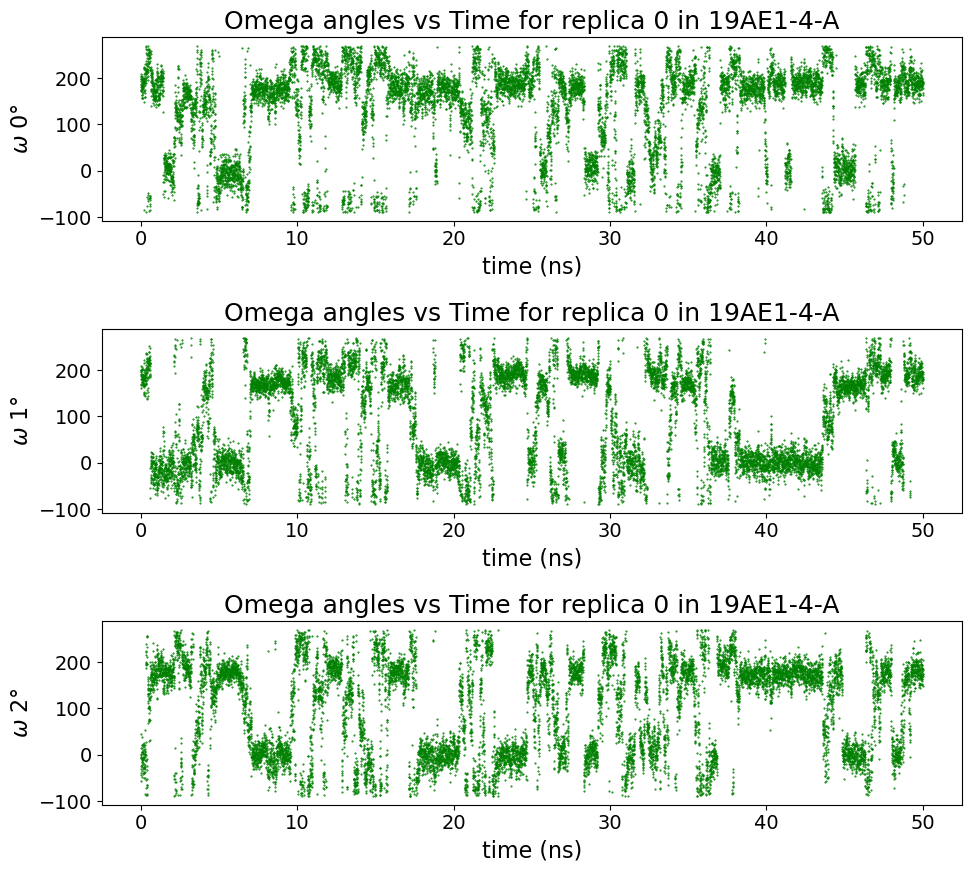

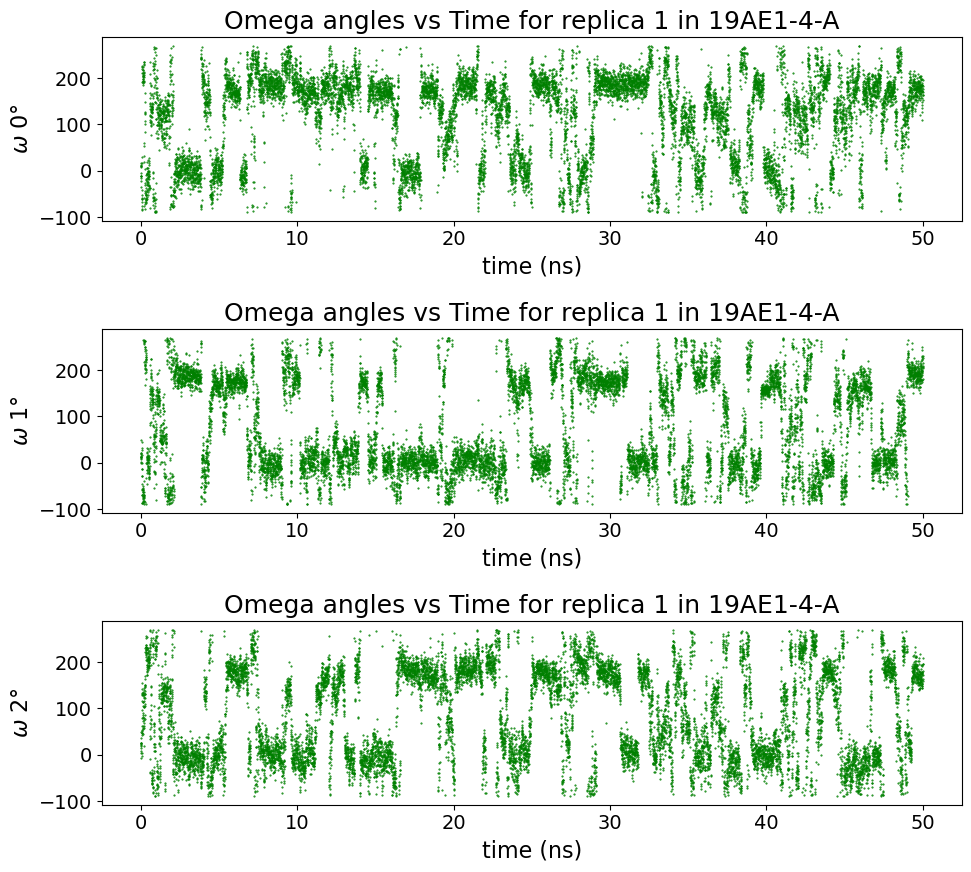

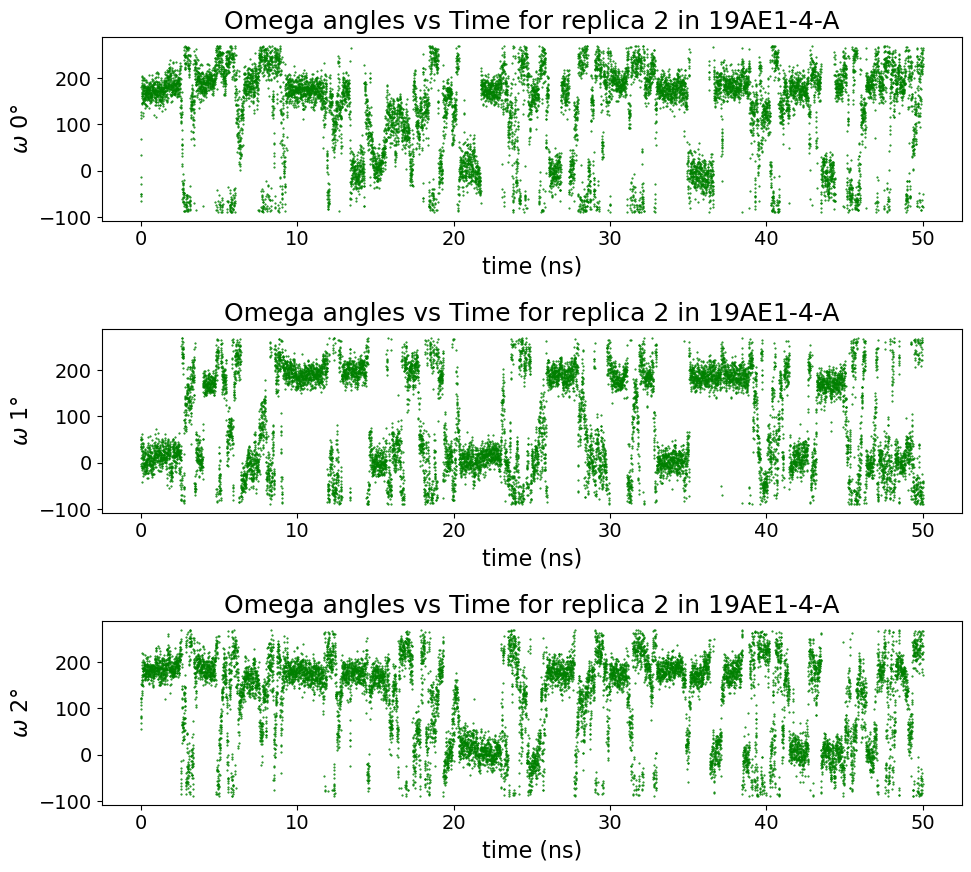

In [30]:
# Adjust omega values into the range (-90, 270)
all_omegas_by_replica = (all_omegas_by_replica + 90.0) % 360.0 - 90.0

start = 0
nsnaps = 12501
nreps = 3
dt_in_ns = 0.004 # ns
residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)

ShowPlots = True

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

# Plot omega angles vs time for selected residues for each replica
for i in range(nreps):
    plt.figure(figsize=(10, 9))
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(num_residues, 1, panel)
        t = np.arange(start, nsnaps) * dt_in_ns  # Time axis in ns
        plt.plot(t, all_omegas_by_replica[i, start:nsnaps, residue], '.', ms=1, color='green')
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ {residue}°')
        plt.title(f'Omega angles vs Time for replica {i} in 19AE1-4-A')
        
    plt.tight_layout()
    if ShowPlots:
        plt.show()
    else:
        outfilename = f'omega_data/Omega_angles_vs_Time_Replica_{i}_in_19AE1-4-A.png'
        plt.savefig(outfilename, format='png', transparent=True, dpi=600)
        print(f"Saved at: {outfilename}")
        plt.clf()  # Clear the figure for the next set of plots

## Omega Density Plot

### Each State

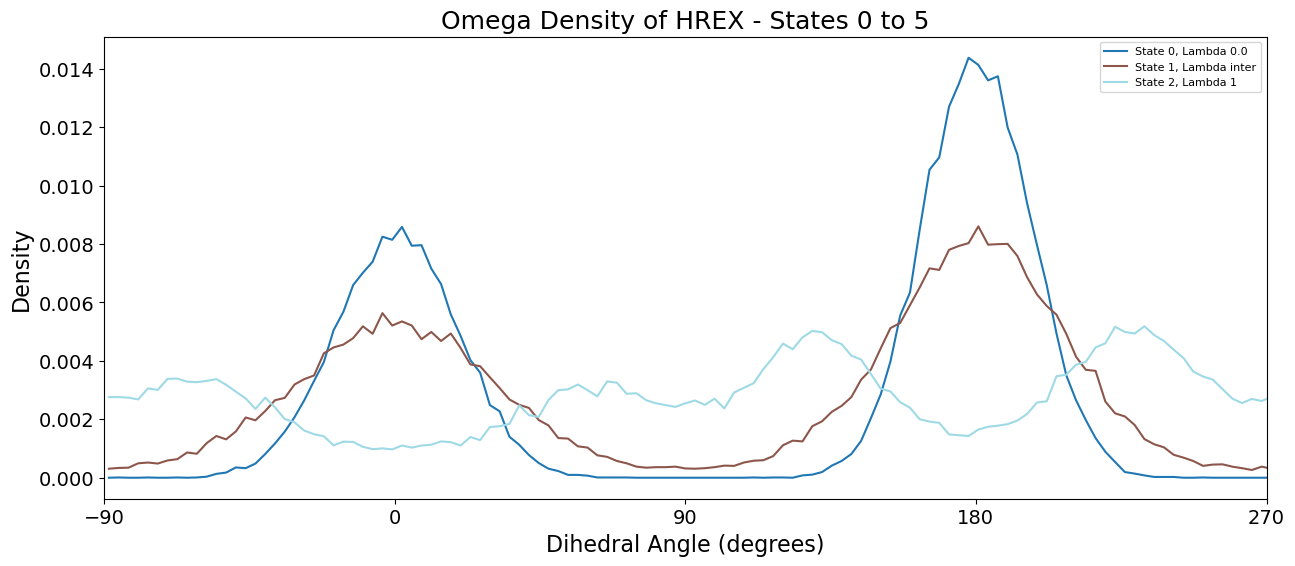

In [31]:
save_dir = 'omega_data'
num_states = 3
lambda_val = ['0.0', 'inter', '1']

fig, ax = plt.subplots(figsize=(15, 6))
cmap = cm.get_cmap('tab20', num_states)
colors = [cmap(i) for i in range(num_states)]

for state in range(num_states):
    omega = Data.load(f"{save_dir}/omegas_state{state}.pkl").array_list  # Load each state
    combined_omega = np.vstack(omega)
    combined_omega = (combined_omega + 90.0) % 360.0 - 90.0

    bins = np.linspace(-90, 270, 120)
    counts, bin_edges = np.histogram(combined_omega, bins=bins, density=True)
    counts = np.concatenate([counts, counts[:1]])
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_centers = np.append(bin_centers, bin_centers[0] + 360)

    ax.plot(bin_centers, counts, color=colors[state], label=f'State {state}, Lambda {lambda_val[state]}')

ax.set_title('Omega Density of HREX - States 0 to 5')
ax.set_xlabel('Dihedral Angle (degrees)')
ax.set_ylabel('Density')
ax.set_xlim([-90, 270])
ax.set_xticks([-90, 0, 90, 180, 270])
ax.legend(loc='best', fontsize=8)

plt.show()


### Each States

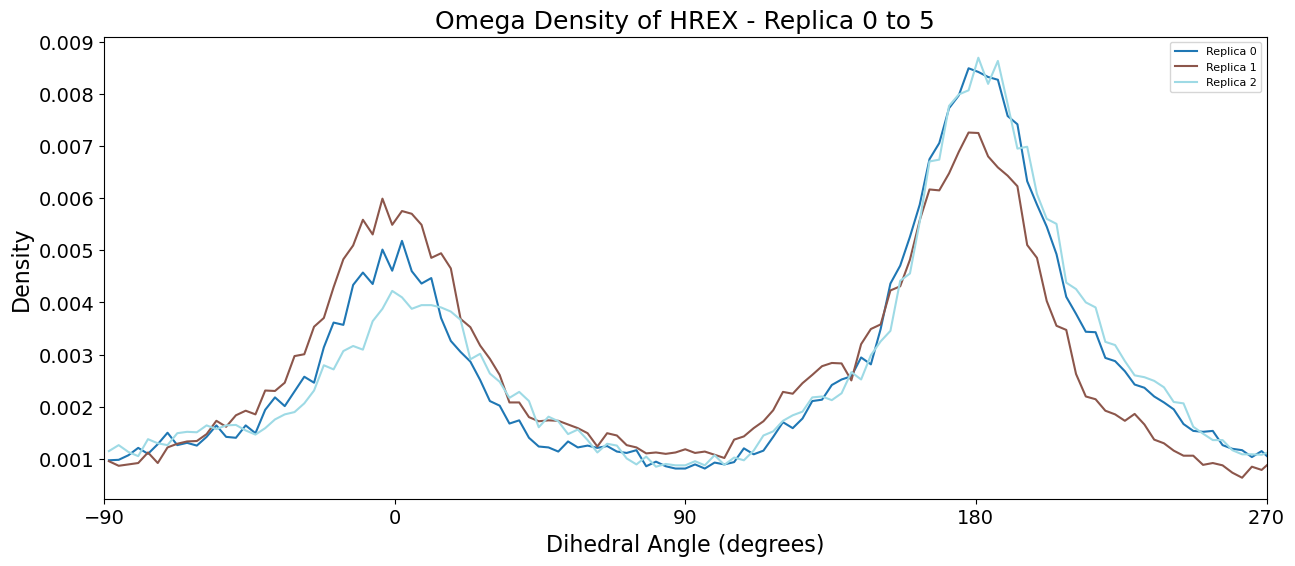

In [32]:
save_dir = 'omega_data'
num_rep = 3

fig, ax = plt.subplots(figsize=(15, 6))
cmap = cm.get_cmap('tab20', num_rep)
colors = [cmap(i) for i in range(num_rep)]

for rep in range(num_rep):
    omega = Data.load(f"{save_dir}/omegas_rep{rep}.pkl").array_list  # Load each state
    combined_omega = np.vstack(omega)
    combined_omega = (combined_omega + 90.0) % 360.0 - 90.0

    bins = np.linspace(-90, 270, 120)
    counts, bin_edges = np.histogram(combined_omega, bins=bins, density=True)
    counts = np.concatenate([counts, counts[:1]])
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_centers = np.append(bin_centers, bin_centers[0] + 360)

    ax.plot(bin_centers, counts, color=colors[rep], label=f'Replica {rep}')

ax.set_title('Omega Density of HREX - Replica 0 to 5')
ax.set_xlabel('Dihedral Angle (degrees)')
ax.set_ylabel('Density')
ax.set_xlim([-90, 270])
ax.set_xticks([-90, 0, 90, 180, 270])
ax.legend(loc='best', fontsize=8)

plt.show()
